# Final E: Plane estimation

For your final, you will be developing plane estimation techniques from RGB-D sensor data.  The simulated robot has an eye-in-hand RGB-D camera, and Klampt can simulate color and depth images that might come from such a sensor.  Plane estimation is an important part of many planning and perception tasks, such as identifying a ground plane, or segmenting objects apart from the table.

In [11]:
%load_ext autoreload
%autoreload 2

#these might be useful
from klampt import *
from klampt.math import so3,se3,vectorops
from IPython.display import display,clear_output,Markdown
import time
import ipywidgets as widgets
import ipyklampt
import numpy as np
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
world = WorldModel()
fn = "data/ur5BlocksSensor.xml"
res = world.readFile(fn)
robot = world.robot(0)

sim = Simulator(world)
controller = sim.controller(0)
camera = controller.sensor('rgbd_camera')

#set the home configuration
qhome  = robot.getConfig()
qhome[1] = 2.1562
qhome[2] = -math.pi/3.0
qhome[3] = math.pi*2/3.0
qhome[4] = 0.48
qhome[5] = math.pi/2.0
robot.setConfig(qhome)

kvis = ipyklampt.KlamptWidget(world)
display(kvis)
controls = widgets.HBox([])
display(controls)
output_area = widgets.Output()
display(output_area)

KlamptWidget(scene={u'object': {u'matrix': [1, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 1], u'uuid': u'be7a0…

HBox()

Output()

## Controls

You may change the robot's configuration using the above sliders, and then  update the camera image by running the cell found 2 cells below this one.

In [13]:
from klampt.model import sensing

xform = sensing.get_sensor_xform(camera,robot)

kvis.add_xform("camera",length=0.1)
kvis.set_transform("camera",*xform)

def setConfig(q):
    robot.setConfig(q)
    kvis.set_transform("camera",*sensing.get_sensor_xform(camera,robot))
    kvis.update()

def getImage():
    camera.kinematicSimulate(world,0.01)
    images = sensing.camera_to_images(camera)
    return images


def onChangeConfig(index,q):
    setConfig(q)
    
configWidget = ipyklampt.EditConfig(robot,link_selector='slider',link_subset=[1,2,3,4,5,6],callback=onChangeConfig)
controls.children = (configWidget,)

interactive(children=(IntSlider(value=0, description=u'Link', max=5), Output()), _dom_classes=(u'widget-intera…

(128, 256, 3)


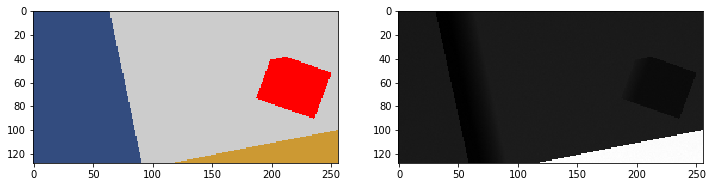

In [14]:
# This cell retrieves and plots the image from the camera sensor

%matplotlib inline
import matplotlib.pyplot as plt

#show the images
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

rgb,depth = getImage()

#there might be a problem with the red and blue channels being swapped
rgb = rgb[:,:,::-1]
print rgb.shape
ax1.imshow(rgb)
ax2.imshow(depth,cmap='gist_gray')
plt.show()


In [15]:
#set a higher configuration
qhigh  = robot.getConfig()
qhigh[1] = 2.3562
qhigh[2] = -2*math.pi/3.0
qhigh[3] = math.pi*2.0/3.0
qhigh[4] = 1.4
qhigh[5] = math.pi/2.0
setConfig(qhigh)

In [16]:
setConfig(qhome)

In [17]:
#get point cloud
pc = sensing.camera_to_points(camera)
print "Converted to point cloud with",pc.shape,"points"
#columns are in the format x,y,z,r,g,b

import random

#corrupt the synthesized point cloud
dstd = 0.01  #approximately 1% error, which is fairly normal for depth sensors
for i in range(pc.shape[0]):
    x,y,z = pc[i][:3]
    znew = random.gauss(z,dstd*z)
    x = x*znew/z
    y = y*znew/z
    pc[i][:3] = [x,y,znew]

world2 = WorldModel()
kvis_pc = ipyklampt.KlamptWidget(world2)
display(Markdown("## Point cloud visualization \n(Note that the X,Y,Z coordinates of the raw point cloud are flipped for better visualization)"))
display(kvis_pc)

Converted to point cloud with (32768, 6) points


## Point cloud visualization 
Note that the X,Y,Z coordinates are flipped for better visualization

KlamptWidget(scene={u'object': {u'matrix': [1, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 1], u'uuid': u'2d57g…

In [18]:
#update the above visualization with the point cloud

subsample = 53
kvis_pc.clear_extras()
kvis_pc.begin_rpc()
for i in range(pc.shape[0]):
    if i % subsample != 0: continue
    x,y,z,r,g,b = pc[i]
    #show it pointing down, for better visualization
    kvis_pc.add_sphere("p"+str(i),-x,-y,-z,r=0.01)
    kvis_pc.set_color("p"+str(i),r,g,b)
kvis_pc.end_rpc()

In [19]:
#make a kvis visualization of the planes

kvis_planes = ipyklampt.KlamptWidget(world2)
display(Markdown("## Plane visualization"))
display(kvis_planes)

## Plane visualization

KlamptWidget(scene={u'object': {u'matrix': [1, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 1], u'uuid': u'66e3a…

In [21]:
import random

MAX_PLANES = 5
PLANE_FIT_TOLERANCE = 0.01

def estimatePlanes(rgb,depth,pc):
    """TODO: find as many planes as possible in the point cloud pc.
    
    Return value is a pair (planes,pointsets) where:
    - planes is a list of planes in the form (a,b,c,d), defining ax+by+cy+d = 0
    - pointsets is a list of point subsets.  Each subset is a list of point indices
      indexing into the pc.
      
    At most MAX_PLANES planes should be returned, and each point in a pointset should 
    be within PLANE_FIT_TOLERANCE distance to the plane
    """
    planes = []
    pointsets = []
    #this is a really bad method
    for p in range(MAX_PLANES):
        points = []
        for i in range(3):
            k = random.randint(0,pc.shape[0]-1)
            points.append(pc[k][:3])
        #fit a plane to these three points
        #note: these are Numpy objects
        normal = np.cross(points[1]-points[0],points[2]-points[0])
        nlen = np.linalg.norm(normal)
        if nlen < 1e-4:
            #degenerate
            continue
        normal = normal / nlen
        offset = -np.dot(normal,points[0])
        planes.append((normal[0],normal[1],normal[2],offset))
        print "normal",normal,"offset",offset
        
        #we're picking any point within 1cm of the plane
        pointset = []
        for i in range(pc.shape[0]):
            #evaluate plane equation -- note the normal is a unit vector
            d = np.dot(pc[i,:3],normal) + offset
            if abs(d) < PLANE_FIT_TOLERANCE:
                pointset.append(i)
        pointsets.append(pointset)
    return planes,pointsets

planes,pointsets = estimatePlanes(rgb,depth,pc)

kvis_planes.clear_extras()
colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(1,0,1)]
for i in range(len(planes)):
    centroid = -np.average(pc[pointsets[i],0:3],axis=0)
    assert len(centroid) == 3
    normal = -np.array(planes[i][0:3])
    offset = planes[i][3]
    y = np.cross(normal,[1,0,0])
    x = -np.cross(y,normal)
    y = y / np.linalg.norm(y)
    x = x / np.linalg.norm(y)
    size = np.std(pc[pointsets[i],0:3])
    print "Plane",i,"has",len(pointsets[i]),"points"
    kvis_planes.begin_rpc()
    centroid = centroid - normal * (np.dot(centroid,normal) + offset)
    a = centroid+(-x-y)*size
    b = centroid+(x-y)*size
    c = centroid+(x+y)*size
    d = centroid+(-x+y)*size
    kvis_planes.add_quad("plane"+str(i),list(a),list(b),list(c),list(d))
    kvis_planes.set_color("plane"+str(i),*colors[i])
    for j in pointsets[i]:
        if j % subsample != 0:
            continue
        x,y,z,r,g,b = pc[j]
        pname = "p"+str(i)+"_"+str(j)
        kvis_planes.add_sphere(pname,-x,-y,-z,0.01)
        kvis_planes.set_color(pname,*colors[i])
    kvis_planes.end_rpc()

normal [-0.02756618 -0.37170969  0.92793966] offset -0.289318221086
normal [-0.14321795 -0.2516967   0.95715066] offset -0.312806613201
normal [-0.12681736  0.36252105 -0.92330702] offset 0.302623717373
normal [-0.81453064  0.42027129  0.39988983] offset -0.173940738024
normal [-0.0838561   0.14163633 -0.98636064] offset 0.325288242957
Plane 0 has 8150 points
Plane 1 has 11385 points
Plane 2 has 7159 points
Plane 3 has 3586 points
Plane 4 has 11883 points


We have provided a fairly garbage plane detector that assumes there are 5 planes in the image, and for each plane picks 3 random points and fits a plane to those points.

## Assignment

Your job is to develop a plane extraction algorithm in estimatePlanes that does a reasonable job of estimating the major planes in the sensed scene.  Each returned plane should have a minimum number of points that "belong" to it (i.e., fit well).  The maximum number of planes and the criterion for "fitting well" should be tunable parameters, as defined by the constants MAX_PLANES and PLANE_FIT_TOLERANCE.

Your strategy can make use of the point cloud (pc), and it can also look into the images rgb and depth.  You should become acquainted with the array representation used in the Numpy package, since it is used for each of these objects.

In your report, precisely and in technical English language (not code, although pseudocode may be acceptable), describe your strategy for generating these planes.  This should include, but is not limited to:

1. Your criterion for defining what is a good plane.

2. The strategy used for identifying good planes.

3. Describe as precisely as possible all of the free parameters of your algorithm.

3. A theoretic analysis of the algorithm's running time. Describe how its performance should vary with respect to the given parameters, as well as any other parameters that you use.

## Unit testing

Perform unit testing of your plane extractor, and describe the performance metrics and test procedure that you are using.  Interpret the observations you have made, including but not limited to:

* Whether performance is sensitive to certain parameters.
* Whether performance limitations or bottlenecks can be identified.
* Whether unit tests agree with theoretical behavior.